In this jupyter notebook, we will attempt to do A/B Testing through the cookie cats dataset.
Cookie Cats is a mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. 

Link of kaggle: https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing/notebook

## Summary of game
As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds

## Data description
The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

userid - a unique number that identifies each player.

version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).

sum_gamerounds - the number of game rounds played by the player during the first week after installation

retention_1 - did the player come back and play 1 day after installing?

retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

## Libraries and dataset read in

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

In [2]:
#Read dataset
df = pd.read_csv('cookie_cats.zip')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Basic Sanity check on dtypes and data

In [3]:
#Verify the number of unique userid
if df['userid'].nunique() == len(df):
    print(f'userid ok \n')
else:
    print(f'{len(df)} unique ids not equivalent \n')
if len(df[~df['version'].isin(['gate_30','gate_40'])]) >0:
    print('diff version of data in dataset')
else:
    print('version ok \n')

#Check sum_gamerounds
if df['sum_gamerounds'].dtypes != 'int64':
    print('sum_gamerounds has non int \n')
else:
    print('sum-gamerounds ok \n')

#Check retention_1
if df['retention_1'].dtypes == 'bool':
    print('retention_1 ok \n')
else:
    print('retention_1 is not bool dtype \n')

#Check retention_7
if df['retention_7'].dtypes == 'bool':
    print('retention_7 ok \n')
else:
    print('retention_7 is not bool dtype \n')

userid ok 

version ok 

sum-gamerounds ok 

retention_1 ok 

retention_7 ok 



In [4]:
#Each userid should only be allocated to one ver of the test
(df.groupby('userid')['version'].count() >1).value_counts()

False    90189
Name: version, dtype: int64

## EDA

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64


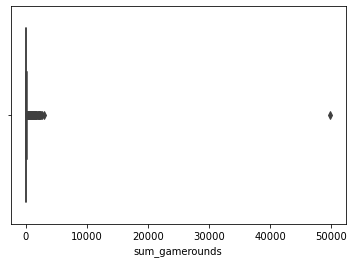

In [5]:
sns.boxplot(x = df["sum_gamerounds"])
print(df["sum_gamerounds"].describe())

Text(0.5, 1.0, 'Boxplot between gate_30,gate_40')

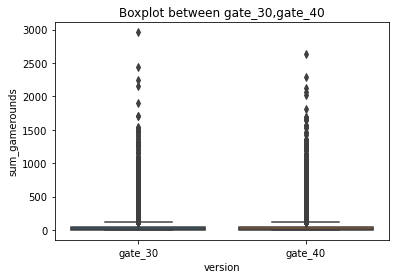

In [6]:
#Removing the outlier and compare both versions
sns.boxplot(data = df,x = 'version',y= df.loc[df["sum_gamerounds"] <40000,'sum_gamerounds'])
plt.title('Boxplot between gate_30,gate_40')

In [7]:
#Removing the outlier and allocating it a variable
df_cleanse = df[df["sum_gamerounds"] <40000].reset_index(drop= True)
# df_cleanse["sum_gamerounds"].nlargest(40)

df_cleanse['sum_gamerounds'].quantile([0.25,0.5,0.75,0.9,0.9,0.95])

#There are quite a number of variability

0.25      5.0
0.50     16.0
0.75     51.0
0.90    134.0
0.90    134.0
0.95    221.0
Name: sum_gamerounds, dtype: float64

In [8]:
#Explore how placing the gate at level 30 and 40 differs in their retention
df_30 = df_cleanse[df_cleanse['version'] =='gate_30']
df_40 = df_cleanse[df_cleanse['version'] =='gate_40']

Text(0.5, 1.0, 'Retention of players after 7 day (False)')

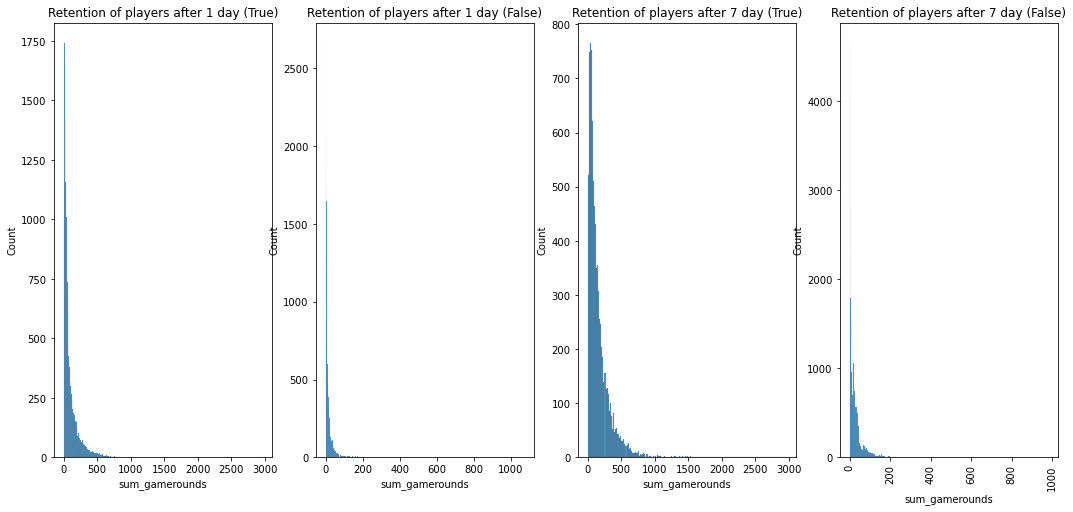

In [20]:
fig , axs = plt.subplots(1,4, figsize =(18,8))
degrees = 90

#retention_1 True
sns.histplot( x= 'sum_gamerounds',data = df_30[df_30['retention_1'] == True],ax =axs[0],palette = 'winter')
axs[0].set_title('Retention of players after 1 day (True)')
plt.xticks(rotation='vertical')

#retention_1 False
sns.histplot( x= 'sum_gamerounds',data = df_30[df_30['retention_1'] == False],ax =axs[1],palette = 'winter')
axs[1].set_title('Retention of players after 1 day (False)')

#retention_7 True
sns.histplot( x= 'sum_gamerounds',data = df_30[df_30['retention_7'] == True],ax =axs[2],palette = 'winter')
axs[2].set_title('Retention of players after 7 day (True)')


#retention_7 False
sns.histplot( x= 'sum_gamerounds',data = df_30[df_30['retention_7'] == False],ax =axs[3],palette = 'winter')
axs[3].set_title('Retention of players after 7 day (False)')


## Gamers who did not play subsequently

In [53]:
#General understanding of the number of people who did not play at all

#total number of players who did not play regardless of retention
total_not_play = df[(df['sum_gamerounds']==0)].shape[0]

#number of players who open the app but not play
not_play = df[(df['sum_gamerounds']==0) & (df['retention_1'] == True) & (df['retention_7'] == True)].shape[0]

#number of players who played after 1 day of installation
played_retent_1 = df[(df['sum_gamerounds'] >0) & (df['retention_1'] == True)].shape[0]

#number of players who played with a week and stop
played_not_retent_1 = df[(df['sum_gamerounds'] >0) & (df['retention_1'] == True) & (df['retention_7'] == False)].shape[0]

#number of players who played after 7 day of installation
played_retent_7 = df[(df['sum_gamerounds'] >0) & (df['retention_7'] == True)].shape[0]

print(f'total number of installers: {len(df)} \n')
print(f'total not played: {total_not_play} ,\npercent: {round(100*(total_not_play/len(df)),2)}%')
print('-'*35)
print(f'Installed but not played: {not_play} ,\npercent: {round(100*(not_play/len(df)),2)}%')
print('-'*35)
print(f'played after 1 day: {played_retent_1} ,\npercent: {round(100*(played_retent_1/len(df)),2)}%')
print('-'*35)
print(f'played within a week and STOP: {played_not_retent_1} ,\npercent: {round(100*(played_not_retent_1/len(df)),2)}%')
print('-'*35)
print(f'played after 7 day: {played_retent_7} ,\npercent: {round(100*(played_retent_7/len(df)),2)}%')

total number of installers: 90189 

total not played: 3994 ,
percent: 4.43%
-----------------------------------
Installed but not played: 5 ,
percent: 0.01%
-----------------------------------
played after 1 day: 40066 ,
percent: 44.42%
-----------------------------------
played within a week and STOP: 26889 ,
percent: 29.81%
-----------------------------------
played after 7 day: 16752 ,
percent: 18.57%


## Number of players who reach gate 30 or 40

In [49]:
#number of players in gate_30 and achieve gate 30
r_gate30_at30 = df_30[(df_30['sum_gamerounds'] >=30)].shape[0]

#number of players in gate_40 and achieve gate 40 
r_gate40_at40 = df_40[(df_40['sum_gamerounds'] >=40)].shape[0]


print(f'Number of players reaching gate 30 while being in gate_30 group: {r_gate30_at30} \
      \n percentage: {round(100*(r_gate30_at30/len(df_30)),2)}%')

print(f'Number of players reaching gate 40 while being in gate_40 group: {r_gate40_at40} \
      \n percentage: {round(100*(r_gate30_at30/len(df_30)),2)}%')

Number of players reaching gate 30 while being in gate_30 group: 16655       
 percentage: 37.26%
Number of players reaching gate 40 while being in gate_40 group: 13827       
 percentage: 37.26%


## Overall gamer churn over sum_gamerounds

In [59]:
df.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

5538


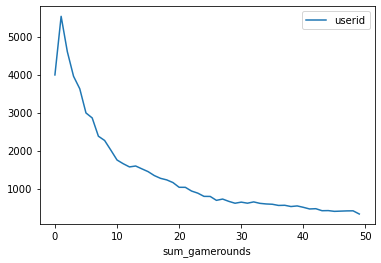

In [68]:
overall_churn = pd.DataFrame(df.groupby('sum_gamerounds')['userid'].count()).head(50)
overall_churn.plot()

print(f'overall_churn['userid'].max())

In [78]:
overall_churn[overall_churn['userid'].isin(overall_churn['userid'].nlargest(5))]

,userid
sum_gamerounds,
0,3994
1,5538
2,4606
3,3958
4,3629


## Bootstraping Method

In [91]:
## This portion is taken from https://www.kaggle.com/code/yufengsui/datacamp-project-mobile-games-a-b-testing/notebook

<AxesSubplot:ylabel='Density'>

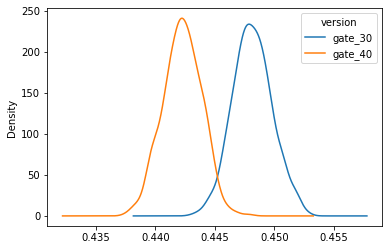

In [93]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

#frac is percentage of sample size, if its 0.25, its 25%
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

Probability that 1-day retention is greater when the gate is at level 30: 0.961


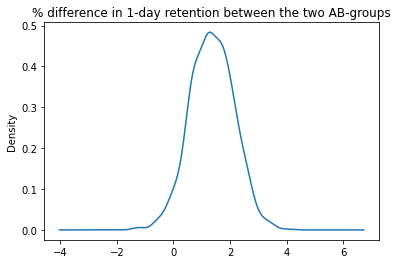

In [86]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40'])/boot_1d['gate_40']*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

Probability that 7-day retention is greater when the gate is at level 30: 0.996


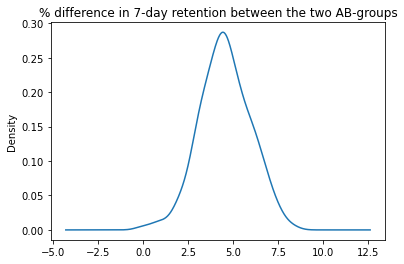

In [96]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40'])/boot_7d['gate_40']*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')

# Calculating the probability that 7-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_7d['diff'] > 0).mean())

<AxesSubplot:ylabel='Density'>

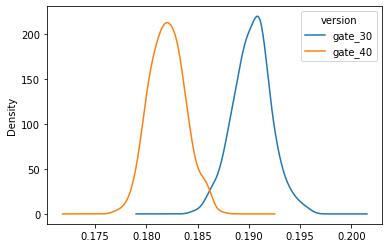

In [98]:
boot_7d[['gate_30','gate_40']].plot(kind='density')